In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from IPython.display import Audio
import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
data_dir = r"C:\Users\neera\TESS Toronto emotional speech set data" # Using a raw string to avoid unicode errors

In [5]:
# Initialize empty lists for features and labels
features = []
labels = []
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        emotion_label = folder.split('_')[-1]  # Extract the emotion label from the folder name
        
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if file_path.endswith('.wav'):
                # Load the audio file and extract features
                audio, sr = librosa.load(file_path, duration=3)  # Adjust the duration as needed
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                features.append(mfcc_mean)
                labels.append(emotion_label)

In [7]:
features = np.array(features)
labels = np.array(labels)

In [9]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [11]:
# Define the emotions and the number of samples to select from each emotion
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
num_samples_per_emotion = 3
# Initialize empty lists for storing the selected samples
selected_samples = []

In [13]:
# Iterate through the emotions and select samples
for emotion in emotions:
    emotion_dir = os.path.join(data_dir, f'OAF_{emotion}')
    audio_files = os.listdir(emotion_dir)
    selected_files = np.random.choice(audio_files, size=num_samples_per_emotion, replace=False)
    
    for file_name in selected_files:
        file_path = os.path.join(emotion_dir, file_name)
        audio, sr = librosa.load(file_path, duration=3)
        selected_samples.append((audio, sr, emotion))


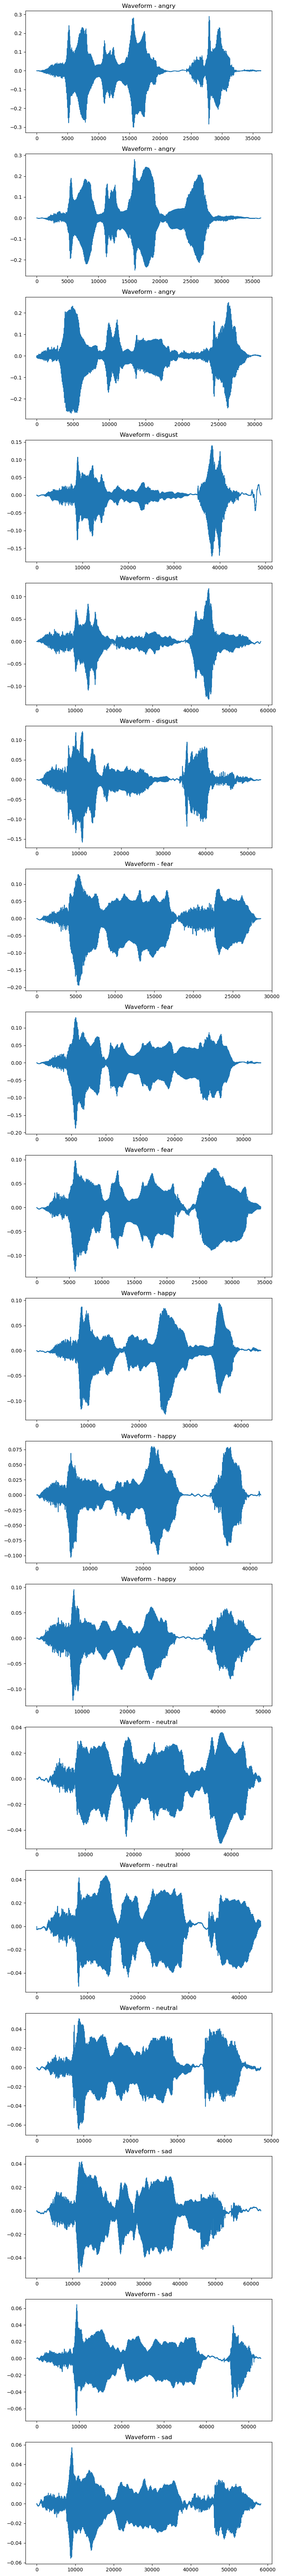

In [15]:
# Plot the selected samples
num_samples = len(selected_samples)
plt.figure(figsize=(8, 4 * num_samples))

for i, (audio, sr, emotion) in enumerate(selected_samples):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(audio)
    plt.title(f'Waveform - {emotion}')

plt.tight_layout()
plt.show()


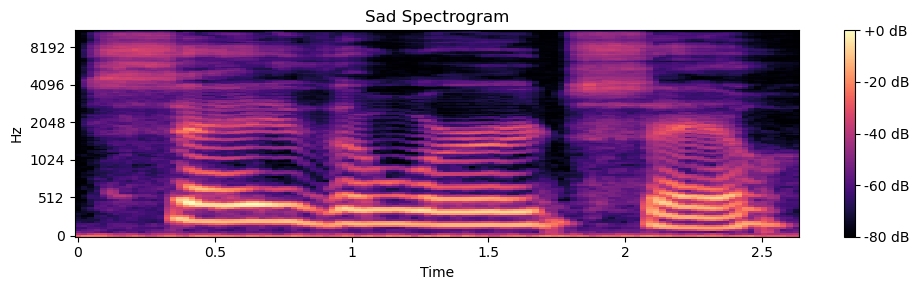

In [17]:
# Calculate the spectrogram
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)

# Convert power spectrogram to dB scale
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 3))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Sad Spectrogram')
plt.tight_layout()
plt.show()
Audio(file_path)

In [27]:
import numpy as np
import librosa

def pitch(data, sampling_rate, pitch_factor=0.7):
    shifted_data = librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor) 
    
    # Ensure consistent length by padding with zeros
    max_length = max(len(data), len(shifted_data))
    padded_data = np.zeros(max_length)
    padded_data[:len(data)] = data
    padded_shifted_data = np.zeros(max_length)
    padded_shifted_data[:len(shifted_data)] = shifted_data
    
    return padded_shifted_data

# Assuming you have your original features and labels (features, labels)

augmented_features = []
augmented_labels = []

for feature, label in zip(features, labels):
    augmented_features.append(feature)
    augmented_labels.append(label)

    # Apply noise addition
    noise = np.random.randn(len(feature))
    augmented_features.append(feature + 0.005 * noise)  # Adjust noise magnitude as needed
    augmented_labels.append(label)

    # Apply time stretching
    augmented_features.append(librosa.effects.time_stretch(feature, rate=1.2))  # Adjust rate as needed
    augmented_labels.append(label)

    # Apply pitch shifting
    augmented_features.append(pitch(feature, sampling_rate=22050, pitch_factor=0.7))  # Adjust sampling_rate and pitch_factor as needed
    augmented_labels.append(label)

# Ensure consistent shape for all features (important!)
max_len = max([len(feat) for feat in augmented_features]) 
augmented_features = np.array([np.pad(feat, (0, max_len - len(feat)), mode='constant') for feat in augmented_features]) 

augmented_labels = np.array(augmented_labels)

# Print the number of original and augmented samples
print('Original samples:', len(features))
print('Augmented samples:', len(augmented_features))

Original samples: 2800
Augmented samples: 11200


In [29]:
# Define a list to store the preprocessed data
preprocessed_data = []
file_list = os.listdir(data_dir)
# Iterate over the files
for filename in file_list:
    file_path = os.path.join(data_dir, filename)
    
    # Skip non-audio files
    if not filename.endswith('.wav'):
        continue

    # Load the audio file and obtain the waveform and sample rate
    waveform, sr = librosa.load(file_path, sr=None, dtype=np.float32)

    # Resample the audio if needed
    if sr != 22050:
        waveform = librosa.resample(waveform, sr, 22050)
        sr = 22050


In [31]:
# Encode the emotion labels
label_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5}
encoded_labels = np.array([label_mapping.get(label, -1) for label in labels])

# Filter out any samples with unknown emotion labels
valid_indices = np.where(encoded_labels != 1)[0]  # Get the indices from the tuple
features = features[valid_indices]
encoded_labels = encoded_labels[valid_indices]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# Reshape the input features
X_train = X_train.reshape((*X_train.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))


# Convert the emotion labels to categorical format
num_classes = len(label_mapping)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [33]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1920, 13, 1)
y_train shape: (1920, 6)
X_test shape: (480, 13, 1)
y_test shape: (480, 6)


In [35]:
#Build the cnn model architeture
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(13, 1, 1), padding='same'))

# Flatten the output
model.add(Flatten())

# Add a dense layer0
model.add(Dense(32, activation='relu'))

# Add the output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 13, 1, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          13,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,862 (54.15 KB)

 Trainable params: 13,862 (54.15 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2001 - loss: 14.4797 - val_accuracy: 0.4583 - val_loss: 2.2169
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4628 - loss: 1.5942 - val_accuracy: 0.5000 - val_loss: 1.0312
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5340 - loss: 0.9754 - val_accuracy: 0.6917 - val_loss: 0.8440
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6895 - loss: 0.7882 - val_accuracy: 0.7229 - val_loss: 0.7306
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7467 - loss: 0.6858 - val_accuracy: 0.7542 - val_loss: 0.6620
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7841 - loss: 0.6105 - val_accuracy: 0.7771 - val_loss: 0.6496
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8024 - loss: 0.5588 - val_accuracy: 0.8083 - val_loss: 0.5540
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8027 - loss: 0.5337 - val_accuracy: 0.8146 - val_los

In [39]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8271 - loss: 0.4644 
Accuracy of our model on test data :  81.25 %


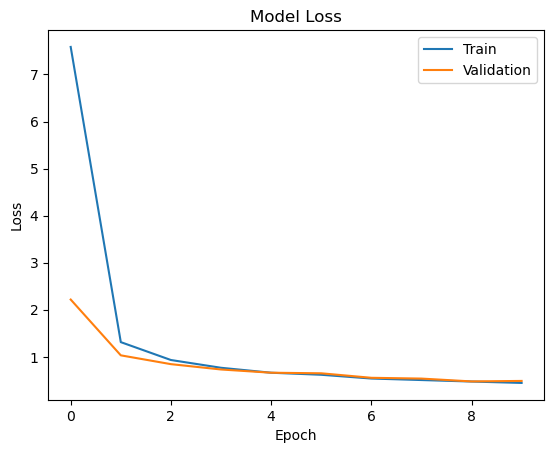

In [41]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

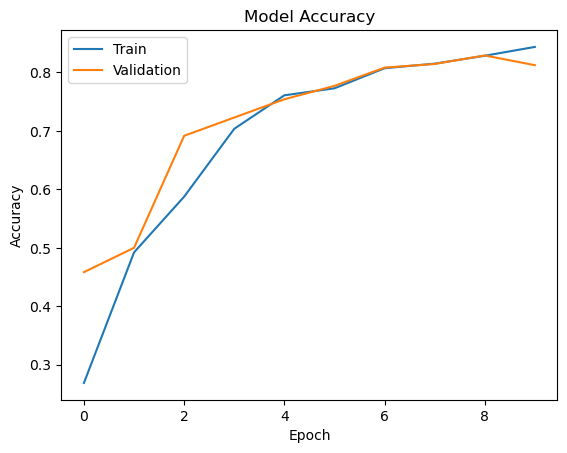

In [43]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


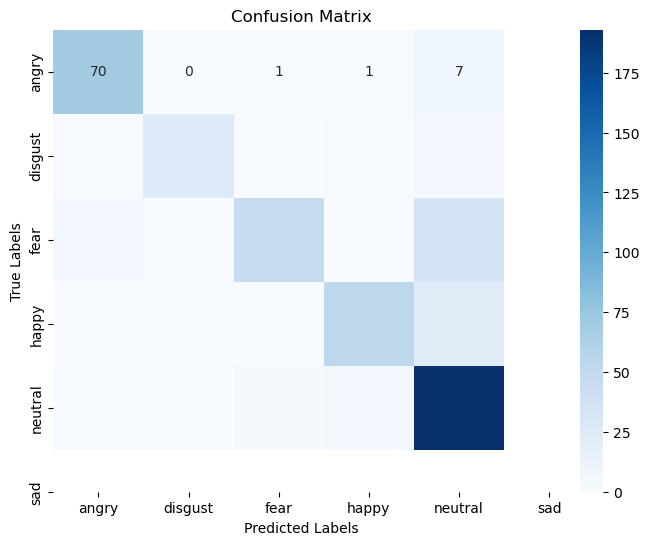

In [45]:
# Get the predicted labels for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert the true labels from one-hot encoding to labels
y_true_labels = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']  # Replace with your actual class names
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, labels=range(len(class_names)))

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [47]:
print(report)

              precision    recall  f1-score   support

       angry       0.91      0.89      0.90        79
     disgust       0.00      0.00      0.00         0
        fear       0.96      0.76      0.85        33
       happy       0.92      0.56      0.70        86
     neutral       0.87      0.68      0.77        79
         sad       0.73      0.95      0.83       203

   micro avg       0.81      0.81      0.81       480
   macro avg       0.73      0.64      0.67       480
weighted avg       0.83      0.81      0.81       480



In [49]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=64)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8525 - loss: 0.4435 - val_accuracy: 0.7986 - val_loss: 0.4980
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8389 - loss: 0.4251 - val_accuracy: 0.7847 - val_loss: 0.5182
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8510 - loss: 0.4148 - val_accuracy: 0.8524 - val_loss: 0.3954
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8687 - loss: 0.3608 - val_accuracy: 0.8368 - val_loss: 0.4118
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8743 - loss: 0.3494 - val_accuracy: 0.8281 - val_loss: 0.4087
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8755 - loss: 0.3621 - val_accuracy: 0.8611 - val_loss: 0.3765
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8742 - loss: 0.3520 - val_accuracy: 0.8576 - val_loss: 0.3705
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8878 - loss: 0.3411 - val_accuracy: 0.8628 - val_

In [51]:
print("Accuracy of our model on train data : " , model.evaluate(X_train,y_train)[1]*100 , "%")

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8741 - loss: 0.3294
Accuracy of our model on train data :  87.55208253860474 %


In [53]:
# Save the model
model.save('cnn_tess_data.h5')